# Sensitivity to initial conditions

In [ ]:
from lucifex.solver import OptionsPETSc
from lucifex.fdm import AB, CN
from lucifex.sim import run, Simulation
from lucifex.viz import plot_colormap, plot_line
from crocodil.dns import dns_system_a, SYSTEM_A_REFERENCE

STORE = 1
NX = 60
NY = 60

def create_simulation(
    c_ampl=1e-6,
    c_freq=(16, 16),
    c_seed=(1234, 5678),
):
    return dns_system_a(
        store_delta=STORE, 
    )(
        Nx=NX,
        Ny=NY,
        scaling='advective',
        **SYSTEM_A_REFERENCE,
        c_ampl=c_ampl,
        c_freq=c_freq,
        c_seed=c_seed,
        D_adv=AB(1)@CN,
        D_diff=AB(1)@CN,
        dt_max=0.1,
        cfl_courant=0.5,
        c_stabilization=None,
        c_limits=None,
        c_petsc=OptionsPETSc('gmres', 'ilu'),
        flow_petsc=(OptionsPETSc('cg', 'hypre'), None),
        diagnostic=True,
    )


ICS_KWARG = 'c_freq'
ics_opts = ((8, 8), (16, 16), (32, 32), (48, 48))
simulations: dict[tuple, Simulation] = {}

for opt in ics_opts:
    simulations[opt] = create_simulation(**{ICS_KWARG: opt})

n_stop = 200
t_stop = 12.0
dt_init = 1e-6
n_init = 10
for opt in ics_opts:
    sim = simulations[opt]
    run(sim, n_stop, t_stop, dt_init=dt_init, n_init=n_init)

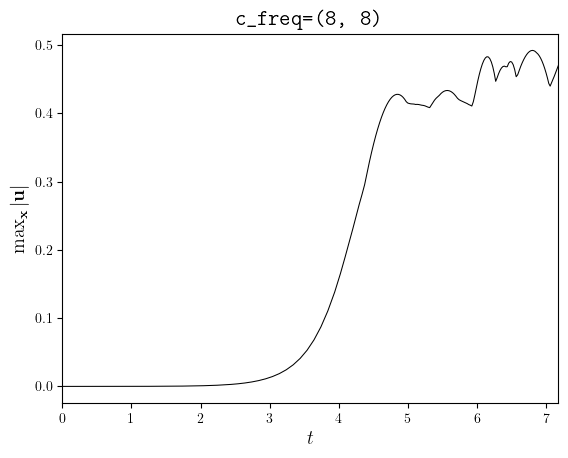

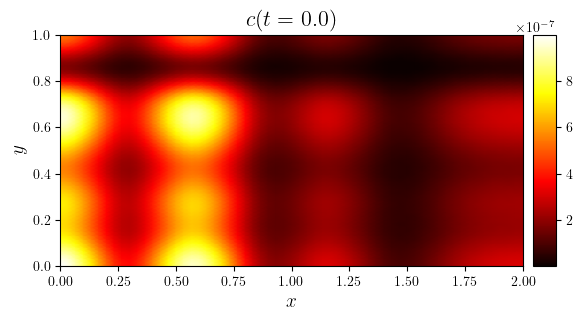

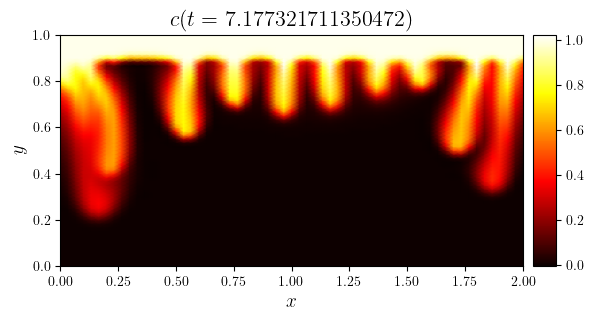

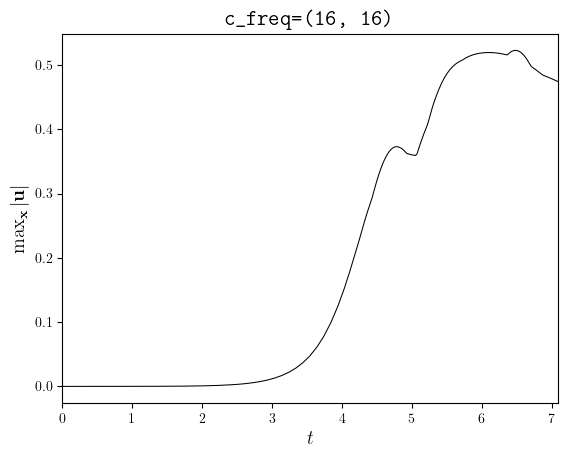

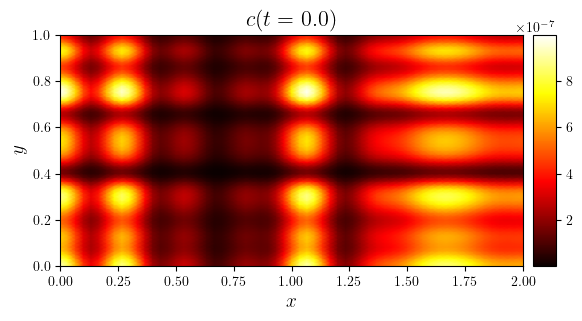

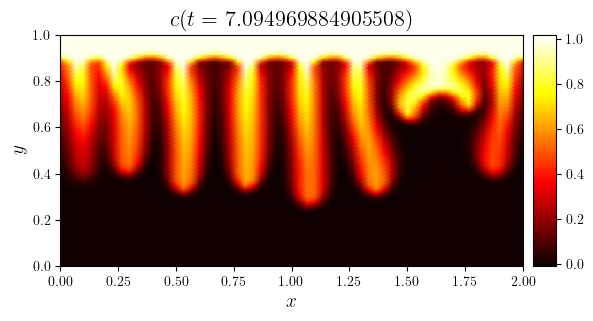

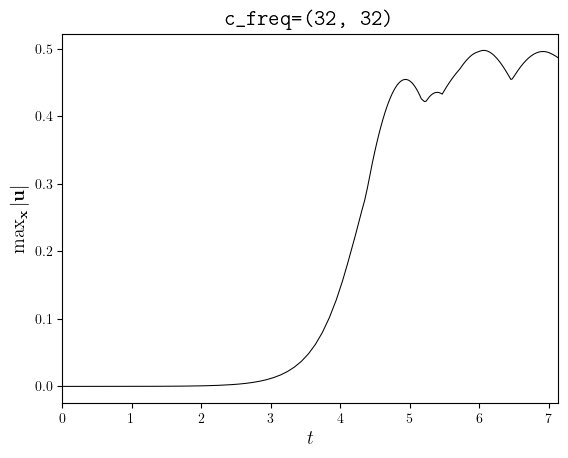

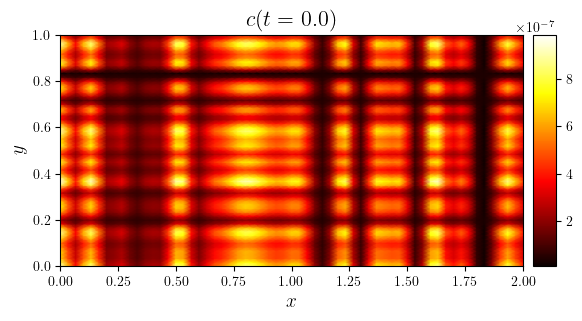

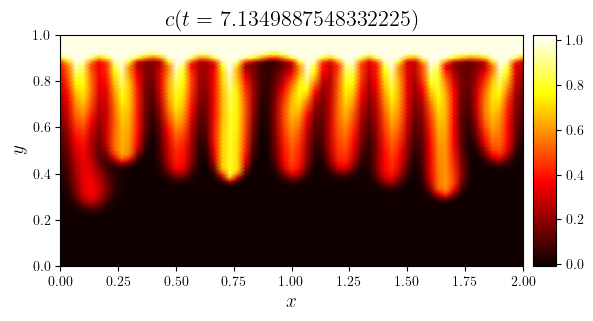

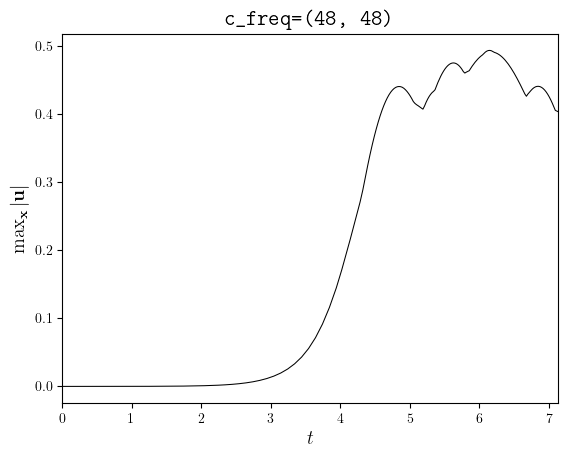

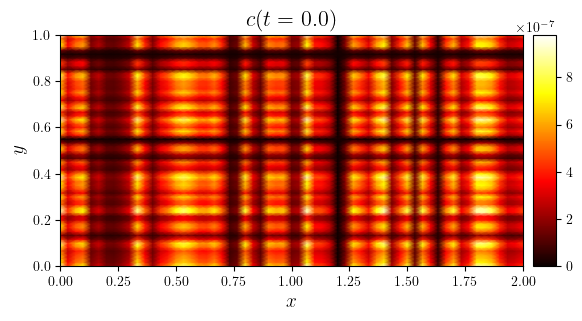

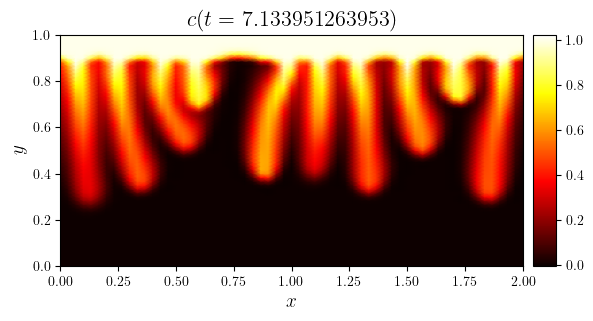

In [3]:
for opt in ics_opts:
    title = f'\\texttt{{{ICS_KWARG}={opt}}}'
    sim = simulations[opt]
    uMinMax = sim['uMinMax']
    uMax = uMinMax.sub(1)
    fig, ax = plot_line(
        (uMax.time_series, uMax.value_series),
        x_label='$t$',
        y_label='$\max_{\mathbf{x}}|\mathbf{u}|$',
        title=title,
    )
    c = sim['c']
    for time_index in (0, -1):
        cmap_title = f'{title}\n $c(t={c.time_series[-1]})$'
        fig, ax = plot_colormap(
            c.series[time_index], 
            title=f'$c(t={c.time_series[time_index]})$',
        )